# Performance comparison of inference on cell cycle

Notebook compares metrics for velocity, latent time and GRN inference across different methods applied to cell cycle data.

## Library imports

In [17]:
import pandas as pd
import numpy as np

from scipy.stats import ttest_ind

import matplotlib.pyplot as plt
import mplscience
import seaborn as sns

from rgv_tools import DATA_DIR, FIG_DIR
from rgv_tools.core import METHOD_PALETTE
from rgv_tools.plotting._significance import add_significance, get_significance

## General settings

In [2]:
DATASET = "cell_cycle"

In [3]:
SAVE_FIGURES = True
if SAVE_FIGURES:
    (FIG_DIR / DATASET).mkdir(parents=True, exist_ok=True)

FIGURE_FORMATE = "svg"

## Constants

In [4]:
NN_SCALE = [10,30,50,70,90,100]
VELO_METHODS = ["regvelo", "velovi"]

In [5]:
VELO_METHOD_PALETTE = {
    "regvelo": "#0173b2",
    "velovi": "#de8f05",
}

## Velocity loading

In [6]:
## Velocity
confi_df = []
    
for scale in NN_SCALE:
    df = pd.read_parquet(DATA_DIR / "results" / f"regvelo_confidence_velocity_{scale}.parquet")
    df["scale"] = scale
    confi_df.append(df)

confi_df = pd.concat(confi_df,axis=0)

## Confidence

In [7]:
confi_df

,velocity_consistency,Dataset,Method,scale
0,0.941898,Cell cycle,regvelo,10
1,0.951289,Cell cycle,regvelo,10
2,0.904966,Cell cycle,regvelo,10
3,0.541206,Cell cycle,regvelo,10
4,0.886754,Cell cycle,regvelo,10
...,...,...,...,...
1141,0.981466,Cell cycle,regvelo,100
1142,0.918879,Cell cycle,regvelo,100
1143,0.921603,Cell cycle,regvelo,100
1144,0.963663,Cell cycle,regvelo,100


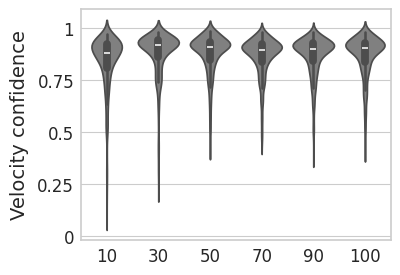

In [8]:
with mplscience.style_context():
    sns.set_style(style="whitegrid")
    fig, ax = plt.subplots(figsize=(4, 3), sharey=True)
    sns.violinplot(
                data=confi_df,
                ax=ax,
                #orient="h",
                x="scale",
                y="velocity_consistency",
                color = "grey",
                order = NN_SCALE,
            );
    #plt.legend(title='', loc='lower center', bbox_to_anchor=(0.5, -0.6), ncol=3)
    ax.set_yticks([0,0.25, 0.5, 0.75,1])
    ax.set_yticklabels([0,0.25, 0.5, 0.75,1]);
    ax.set_ylabel('Velocity confidence',fontsize = 14)
    ax.set_xlabel("")
    plt.show()
    
    if SAVE_FIGURES:
        fig.savefig(
            FIG_DIR / "velocity_confidence_compare.svg", format="svg", transparent=True, bbox_inches="tight"
        )
    plt.show()

## Compare on each level

In [9]:
confi_dfs = []
for scale in NN_SCALE:
    
    confi_df = []
    for method in VELO_METHODS:
        df = pd.read_parquet(DATA_DIR / "results" / f"{method}_confidence_velocity_{scale}_nn30.parquet")
        confi_df.append(df)
        
    confi_df = pd.concat(confi_df,axis=0)
    confi_df["Scale"] = scale
    confi_dfs.append(confi_df)

In [10]:
confi_dfs = pd.concat(confi_dfs)

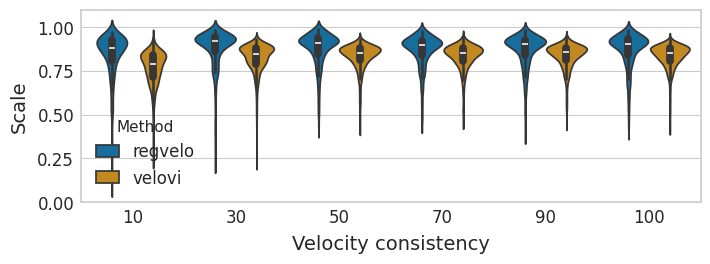

In [11]:
with mplscience.style_context():
    sns.set_style(style="whitegrid")
    fig, ax = plt.subplots(figsize=(8,2.5))
    sns.violinplot(
        data=confi_dfs, y="velocity_consistency", x="Scale", hue="Method", hue_order=["regvelo","velovi"], palette=VELO_METHOD_PALETTE, ax=ax
    )
    
    ax.set(
        xlabel="Velocity consistency",
        ylabel="Scale",
        yticks=ax.get_yticks(),
    )
    ax.set_ylim(0,1.1)

    fig.savefig(
        FIG_DIR / "velocity_confidence.svg", 
        format="svg",
        transparent=True,
        bbox_inches="tight",
    )

    plt.show()

In [12]:
confi_dfs_velo = confi_dfs.copy()

In [13]:
confi_dfs = []
for scale in NN_SCALE:
    
    confi_df = []
    for method in VELO_METHODS:
        df = pd.read_parquet(DATA_DIR / "results" / f"{method}_confidence_time_{scale}_nn30.parquet")
        confi_df.append(df)
        
    confi_df = pd.concat(confi_df,axis=0)
    confi_df["Scale"] = scale
    confi_dfs.append(confi_df)

In [14]:
confi_dfs = pd.concat(confi_dfs)

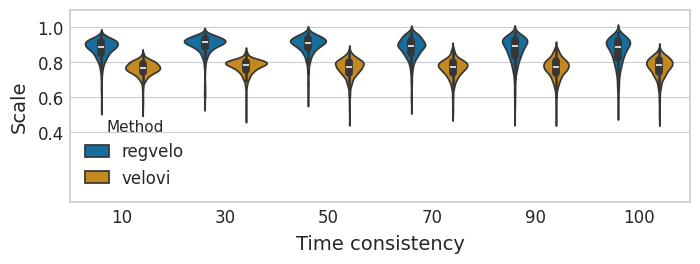

In [15]:
with mplscience.style_context():
    sns.set_style(style="whitegrid")
    fig, ax = plt.subplots(figsize=(8,2.5))
    sns.violinplot(
        data=confi_dfs, y="fit_t_consistency", x="Scale", hue="Method", hue_order=["regvelo","velovi"], palette=VELO_METHOD_PALETTE, ax=ax
    )
    
    ax.set(
        xlabel="Time consistency",
        ylabel="Scale",
        yticks=ax.get_yticks(),
    )
    ax.set_ylim(0,1.1)

    fig.savefig(
        FIG_DIR / "time_confidence.svg", 
        format="svg",
        transparent=True,
        bbox_inches="tight",
    )

    plt.show()

In [16]:
confi_dfs_time = confi_dfs.copy()

In [18]:
confi_dfs_velo_ratio = []
for scale in np.unique(confi_dfs_velo["Scale"]):
    dat = pd.DataFrame()
    repeat = int(int(np.sum(confi_dfs_velo["Scale"] == scale))/2)
    dat["Scale"] = [scale] * repeat
    velo_reg = confi_dfs_velo.loc[(confi_dfs_velo["Scale"] == scale) * (confi_dfs_velo["Method"] == "regvelo"),"velocity_consistency"]
    velo_vi = confi_dfs_velo.loc[(confi_dfs_velo["Scale"] == scale) * (confi_dfs_velo["Method"] == "velovi"),"velocity_consistency"]
    dat["Ratio"] = velo_reg / velo_vi
    dat["Class"] = ["velocity"] * repeat
    confi_dfs_velo_ratio.append(dat)

In [19]:
confi_dfs_time_ratio = []
for scale in np.unique(confi_dfs_time["Scale"]):
    dat = pd.DataFrame()
    repeat = int(int(np.sum(confi_dfs_time["Scale"] == scale))/2)
    dat["Scale"] = [scale] * repeat
    time_reg = confi_dfs_time.loc[(confi_dfs_time["Scale"] == scale) * (confi_dfs_time["Method"] == "regvelo"),"fit_t_consistency"]
    time_vi = confi_dfs_time.loc[(confi_dfs_time["Scale"] == scale) * (confi_dfs_time["Method"] == "velovi"),"fit_t_consistency"]
    dat["Ratio"] = time_reg / time_vi
    dat["Class"] = ["time"] * repeat
    confi_dfs_time_ratio.append(dat)

In [20]:
confi_dfs_velo_ratio = pd.concat(confi_dfs_velo_ratio)
confi_dfs_time_ratio = pd.concat(confi_dfs_time_ratio)
confi_df_all = pd.concat([confi_dfs_velo_ratio,confi_dfs_time_ratio])

In [21]:
confi_df_all

,Scale,Ratio,Class
0,10,1.111715,velocity
1,10,1.087845,velocity
2,10,1.113454,velocity
3,10,0.976719,velocity
4,10,1.001859,velocity
...,...,...,...
1141,100,1.124350,time
1142,100,1.139394,time
1143,100,1.109670,time
1144,100,1.142055,time


In [22]:
confi_df_all["Scale"] = confi_df_all["Scale"].astype(str)

In [23]:
confi_df_all["Ratio"] = confi_df_all["Ratio"].astype(np.float32)

In [24]:
confi_df_all["Ratio"] = np.log2(confi_df_all["Ratio"])

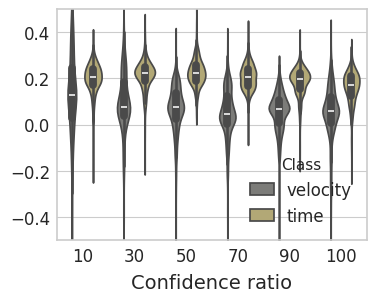

In [25]:
custom_palette = {
    'velocity': '#7D7C78',  # Elegant blue (colorblind-friendly)
    'time': '#BCAE6C',  # Gold-orange (also friendly and high contrast)
}

with mplscience.style_context():
    sns.set_style(style="whitegrid")
    fig, ax = plt.subplots(figsize=(4,3), sharey=True)
    sns.violinplot(
                data=confi_df_all,
                ax = ax,
                y="Ratio",
                x="Scale",
                hue = "Class",
                palette=custom_palette, 
            )
    #plt.legend(title='', loc='lower center', bbox_to_anchor=(0.5, -0.6), ncol=3)
    ax.set_ylim(-0.5,0.5)
    #ax.set_yticklabels([0,0.25, 0.5, 0.75,1]);
    ax.set_xlabel('Confidence ratio',fontsize = 14)
    ax.set_ylabel("")
    plt.show()
    
    if SAVE_FIGURES:
        fig.savefig(FIG_DIR / "confi_all_kinetics.svg", format="svg", transparent=True, bbox_inches="tight")
    plt.show()